# Implementação de Transfer Learning com Fully Convolutional Network (FCN)

Nesse notebook, faremos o processo de transfer learning com uma Rede Convolucional Completa (FCN-DK5), extraída do projeto "Automatic Delineation of Agricultural Fields from Sentinel-2 Images" da University of Twente

O projeto com o modelo que usamos encontra-se disponível nas referências abaixo.

## Referências:

- Resign M. et al, 2021: Automatic Delineation of Agricultural Fields from Sentinel-2 Images. Disponível em: https://github.com/resingm/field-boundary-delineation/blob/master/paper.pdf. Acesso em 5 de maio de 2024.

- Resign M. et al, 2021. Repositório GitHub, acesso em 5 de maio de 2024, https://github.com/resingm/field-boundary-delineation/tree/master

## Como executar

Para executar esse notebook com CPU ou GPU siga os passos abaixo:
1. Baixe este notebook e importe para o <a href="https://colab.google/">Google Colab</a>
2. No menu superior direito do colab, onde está escrito "Conectar" ou "Ligar", clique na seta ao lado e escolha a opção "Alterar o tipo de ambiente de execução"
3. Uma janela será aberta onde você pode escolher entre utilizar CPU ou GPU. 
4. Para rodar este notebook, alguns arquivos são necessários. Acesse https://drive.google.com/drive/folders/1vcymtzjDJqVRd3x0ivSywnouhkqotq5J?usp=sharing e baixe os dois arquivos da pasta chamados "X" e "Y". Caso prefira, poderá salvá-los em seu Google Drive, criando uma cópia. Esses são os dados que serão utilizados no modelo ("X" e "Y" são os dados prontos e são suficientes caso deseje ir diretamente para o treinamento, pulando a etapa "Preparação final dos Dados".).
5. Baixe também o modelo prétreinado, disponível [nesse link](https://github.com/resingm/field-boundary-delineation/blob/master/FCN-DK5/653e6d98-5974-11eb-a09d-0242ac1c0002-FCNDK5-model.h5) e coloque o arquivo no Google Drive com o nome '/Models/FCNDK5.h5'

Caso tenha baixado localmente:

6. Aguarde o download dos arquivos. Após, no menu lateral esquerdo do colab clique no ícone de pasta (último ícone), e depois no primeiro ícone para upload de arquivos ("Fazer upload para o armazenamento da sessão").
7. Adicione os dois arquivos previamente baixados.

Pronto! Já está tudo preparado para execução.

<strong>OBS: Caso deseje alterar de CPU para GPU, ou vice-versa, durante a execução, a sessão será reiniciada e tudo deverá ser executado novamente.





In [ ]:
import psutil

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import keras
import pickle
import pandas as pd
import tensorflow as tf
from keras import Input
from keras.datasets import cifar10
from keras.utils import to_categorical, Sequence
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Conv2DTranspose, concatenate, Dropout, UpSampling2D
from sklearn.model_selection import train_test_split
import time


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Leitura dos dados

Os dados das imagens (X) e dos arquivos de máscara (Y) já foram codificados previamente como arquivos .pkl no Google Drive para otimizar o armazenamento. Vamos carregá-los e usá-los para o processo de transfer learning.

In [27]:
file_x = open('/content/drive/MyDrive/Satelite Data/loaded_df/X.pkl', 'rb')

X = pickle.load(file_x)

file_y = open('/content/drive/MyDrive/Satelite Data/loaded_df/Y.pkl', 'rb')

Y = pickle.load(file_y)

file_x.close()
file_y.close()


In [28]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 0.8 or logs.get('val_accuracy') >= 0.8):
      print("\nAtingímos uma precisão maior ou igual a 80.0% então podemos parar o treino!")
      self.model.stop_training = True

In [29]:
def memory_usage_psutil():
    process = psutil.Process()
    mem = process.memory_info().rss / float(2 ** 20)  # em MB
    return mem

# Transfer Learning

Vamos iniciar o processo de transfer learning importando o modelo e alterando suas camadas.

In [ ]:
import numpy as np

# X é o array com o shape original (tamanho_do_batch, 208, 208, 3)
batch_size = X.shape[0]

# Criar um novo canal para a mascara
new_channel = np.ones((batch_size, 208, 208, 1))

# Concatenar o X antigo (RGB) com a mascara
new_X = np.concatenate((X, new_channel), axis=-1)

print(new_X.shape)

(2160, 208, 208, 4)


In [ ]:
X.shape

(2160, 208, 208, 3)

In [ ]:
from keras import layers
from keras import Model
from keras.models import Sequential, load_model
from keras.optimizers import RMSprop
from keras.layers import UpSampling2D, Conv2D, Input, Activation, Resizing, Activation, BatchNormalization
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.optimizers import Adam

In [ ]:
# Normalizar X
X = X / 255.0

# Assegurar que Y esta no formato correto
Y = Y.astype(np.float32)

# Carregar o modelo FCNDK5
model_path = "/content/drive/MyDrive/Models/FCNDK5.h5"
model = load_model(model_path)

# Ajustar a camada de input para o novo shape do dataset
input_layer = Input(shape=(208, 208, 4), name='input_new')
x = input_layer

# Aplicar algumas das camadas do modelo original
for layer in model.layers[1:]:  # Pular a camada de "input" do modelo original
    if isinstance(layer, Conv2D):
        x = Conv2D(layer.filters, layer.kernel_size, strides=layer.strides,
                   padding='same', activation=layer.activation, name=layer.name)(x)
    elif isinstance(layer, BatchNormalization):
        x = BatchNormalization()(x)

# Fazer um Upsampling para voltar ao tamanho normal
x = UpSampling2D(size=(1.107, 1.107))(x)

# Camada de convolucao final para dar output na mascára
x = Conv2D(1, (1, 1), activation="sigmoid", padding="same", name="output_conv")(x)

# Criar o novo modelo
new_model = Model(inputs=input_layer, outputs=x)
new_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Mostrar o sumário do modelo
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_new (InputLayer)      [(None, 208, 208, 4)]     0         
                                                                 
 conv2d (Conv2D)             (None, 208, 208, 16)      1616      
                                                                 
 batch_normalization (Batch  (None, 208, 208, 16)      64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 208, 208, 32)      12832     
                                                                 
 batch_normalization_1 (Bat  (None, 208, 208, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_2 (Conv2D)           (None, 208, 208, 32)      2563

## Treinar o modelo

In [ ]:
total_params = new_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in new_model.trainable_weights])

print(f"Total de parâmetros no modelo é de {total_params:,}.")
print(f"Total de parâmetros que podem ser treinados no modelo são {num_trainable_params:,}.")

Total de parâmetros no modelo é de 91,989.
Total de parâmetros que podem ser treinados no modelo são 91,701.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_X, Y, test_size=0.3)

In [ ]:
import time

start_fit_time = time.time()

results = new_model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))

elapsed_fit_time = time.time() - start_fit_time

elapsed_fit_time

Epoch 1/50
48/48 [==============================] - 4s 89ms/step - loss: 0.5837 - accuracy: 0.7156 - val_loss: 0.5954 - val_accuracy: 0.6978
Epoch 2/50
48/48 [==============================] - 3s 65ms/step - loss: 0.5826 - accuracy: 0.7150 - val_loss: 0.5944 - val_accuracy: 0.6966
Epoch 3/50
48/48 [==============================] - 3s 64ms/step - loss: 0.5813 - accuracy: 0.7191 - val_loss: 0.5935 - val_accuracy: 0.7002
Epoch 4/50
48/48 [==============================] - 3s 64ms/step - loss: 0.5802 - accuracy: 0.7174 - val_loss: 0.5893 - val_accuracy: 0.7039
Epoch 5/50
48/48 [==============================] - 3s 65ms/step - loss: 0.5807 - accuracy: 0.7199 - val_loss: 0.5934 - val_accuracy: 0.6964
Epoch 6/50
48/48 [==============================] - 3s 65ms/step - loss: 0.5799 - accuracy: 0.7199 - val_loss: 0.5915 - val_accuracy: 0.7100
Epoch 7/50
48/48 [==============================] - 3s 64ms/step - loss: 0.5791 - accuracy: 0.7227 - val_loss: 0.5869 - val_accuracy: 0.7195
Epoch 8/50
48

158.43920397758484

## Gráfico dos Resultados

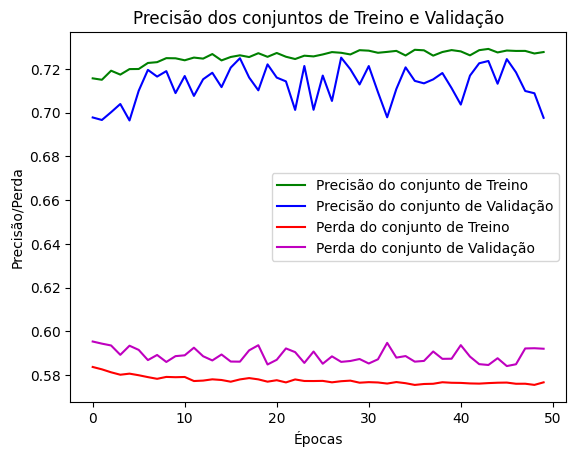

<Figure size 640x480 with 0 Axes>

In [ ]:
def plot_results(results):
  acc = results.history['accuracy']
  val_acc = results.history['val_accuracy']
  loss = results.history['loss']
  val_loss = results.history['val_loss']
  epochs = range(len(acc))
  plt.plot(epochs, acc, 'g', label='Precisão do conjunto de Treino')
  plt.plot(epochs, val_acc, 'b', label='Precisão do conjunto de Validação')
  plt.plot(epochs, loss, 'r', label='Perda do conjunto de Treino')
  plt.plot(epochs, val_loss, 'm', label='Perda do conjunto de Validação')
  plt.title('Precisão dos conjuntos de Treino e Validação')
  plt.xlabel('Épocas')
  plt.ylabel('Precisão/Perda')
  plt.legend(loc=0)
  plt.figure()
  plt.show()


plot_results(results)